In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법

## 데이터 Preprocessing

In [38]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
house_df = house_df_org.copy() # 데이터 가공을 많이 수행할 예정이므로 복사해놓기
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [39]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


Null 값이 너무 많은 피처는 드랍한다.

타깃 값의 분포는 정규 분포인가?

<AxesSubplot:title={'center':'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

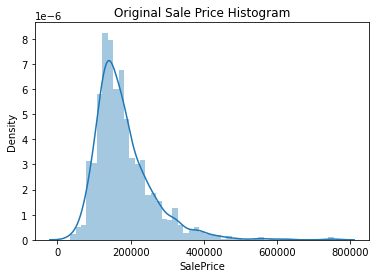

In [40]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

정규분포가 아니므로 로그변환 적용

<AxesSubplot:title={'center':'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

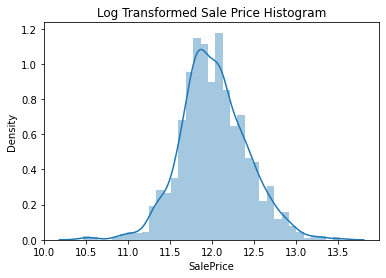

In [41]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

- log_SalePrice를 df에 반영
- Null 값이 많은 피처를 삭제
- Id도 단순 식별자이므로 삭제
- LotFrontage는 Null이 259개로 비교적 많으나 평균값으로 대체
- 나머지 Null 피처는 숫자형의 경우 평균값으로 대체

In [42]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

# 드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

In [43]:
# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


문자형 피처를 제외하고는 Null 값이 없다. 문자형 피처는 원-핫 인코딩을 적용해보자.

In [44]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type :
 Series([], dtype: object)


원핫인코딩 결과, 칼럼수가 75개에서 272개로 증가했다.

Null 값을 가진 피처는 존재하지 않는다. get_dummies()는 문자열 Null을 'None'칼럼으로 대체해준다.

## 선형 회귀 모델

자주 사용할 RMSE 측정 함수를 먼저 만들자

In [48]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [49]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.1318957657915435, 0.12750846334053023, 0.17628250556471398]

### 피처별 회귀 계수를 살펴보자

In [50]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 시리즈 객체를 생성. index는 칼럼명
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # 상위 10개, 하위 10개의 계수를 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

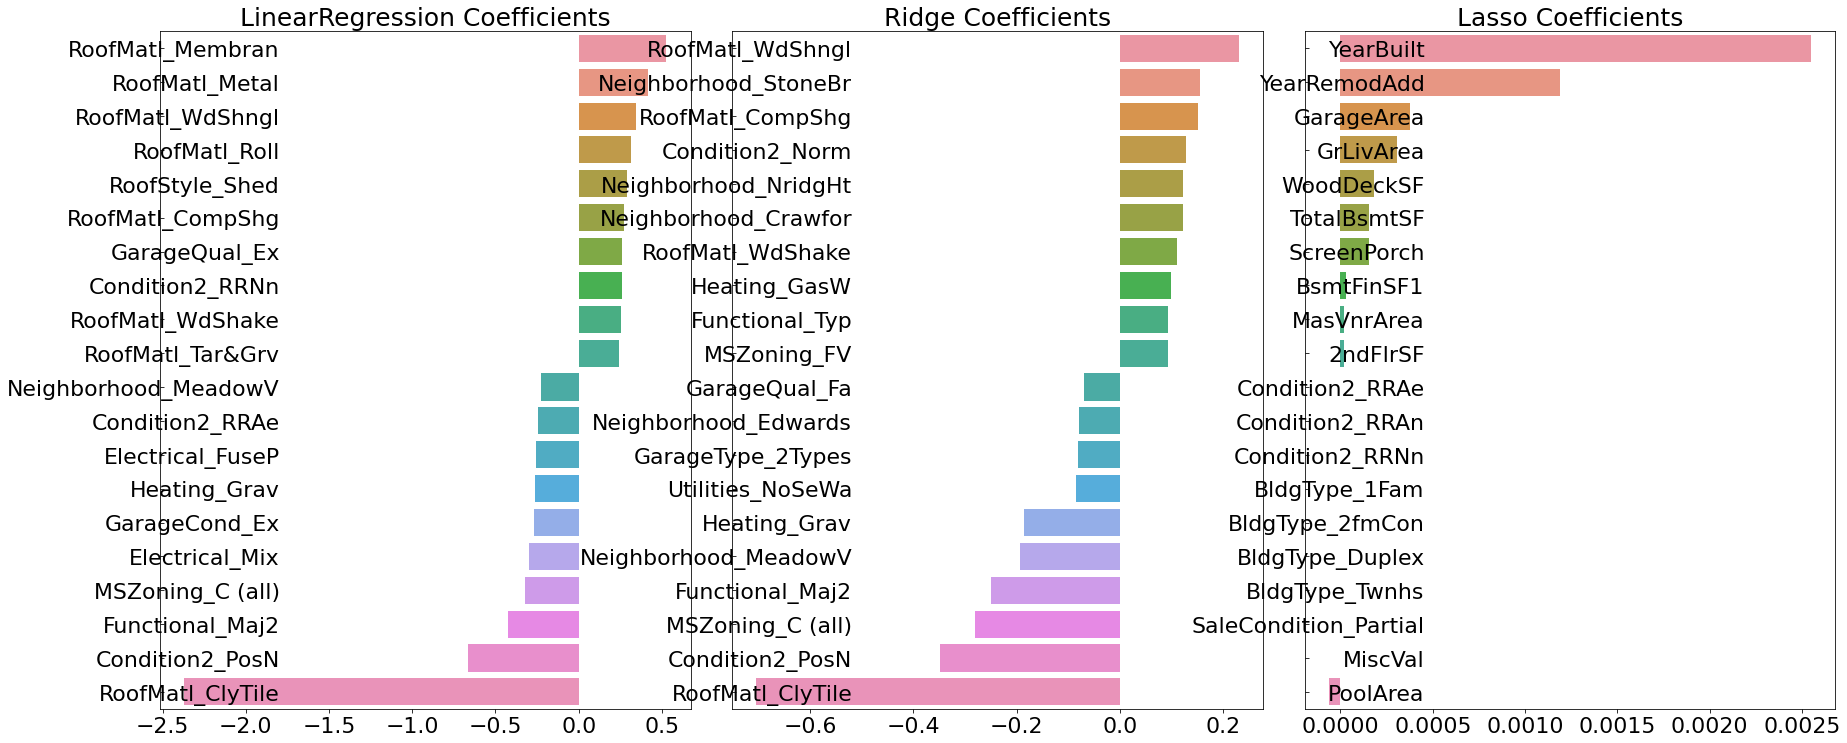

In [52]:
def visualize_coefficient(models):
    # 3개의 회귀 모델의 시각화
    figs, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    figs.tight_layout()
    # 차례대로 model를 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # ax subplot에 barchar로 표현.
        axs[i_num].set_title(model.__class__.__name__+' Coefficients', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])
        
models = [lr_reg, ridge_reg, lasso_reg]        
visualize_coefficient(models)

OLS기반의 선형회귀와 릿지회귀의 계수는 유사한 형태이지만 라쏘는 전체적으로 계수 값이 매우 작고, 그 중에 YearBuilt가 가장 크고 나머지는 너무 작다. 데이터 분할의 문제인지? 교차검증을 해보자

In [53]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


여전히 라쏘의 경우 성능이 떨어진다. 릿지와 라쏘 모델에 대해서 alpha 하이퍼 파라미터를 변화시키면서 최적 값을 도출해보자.

In [54]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


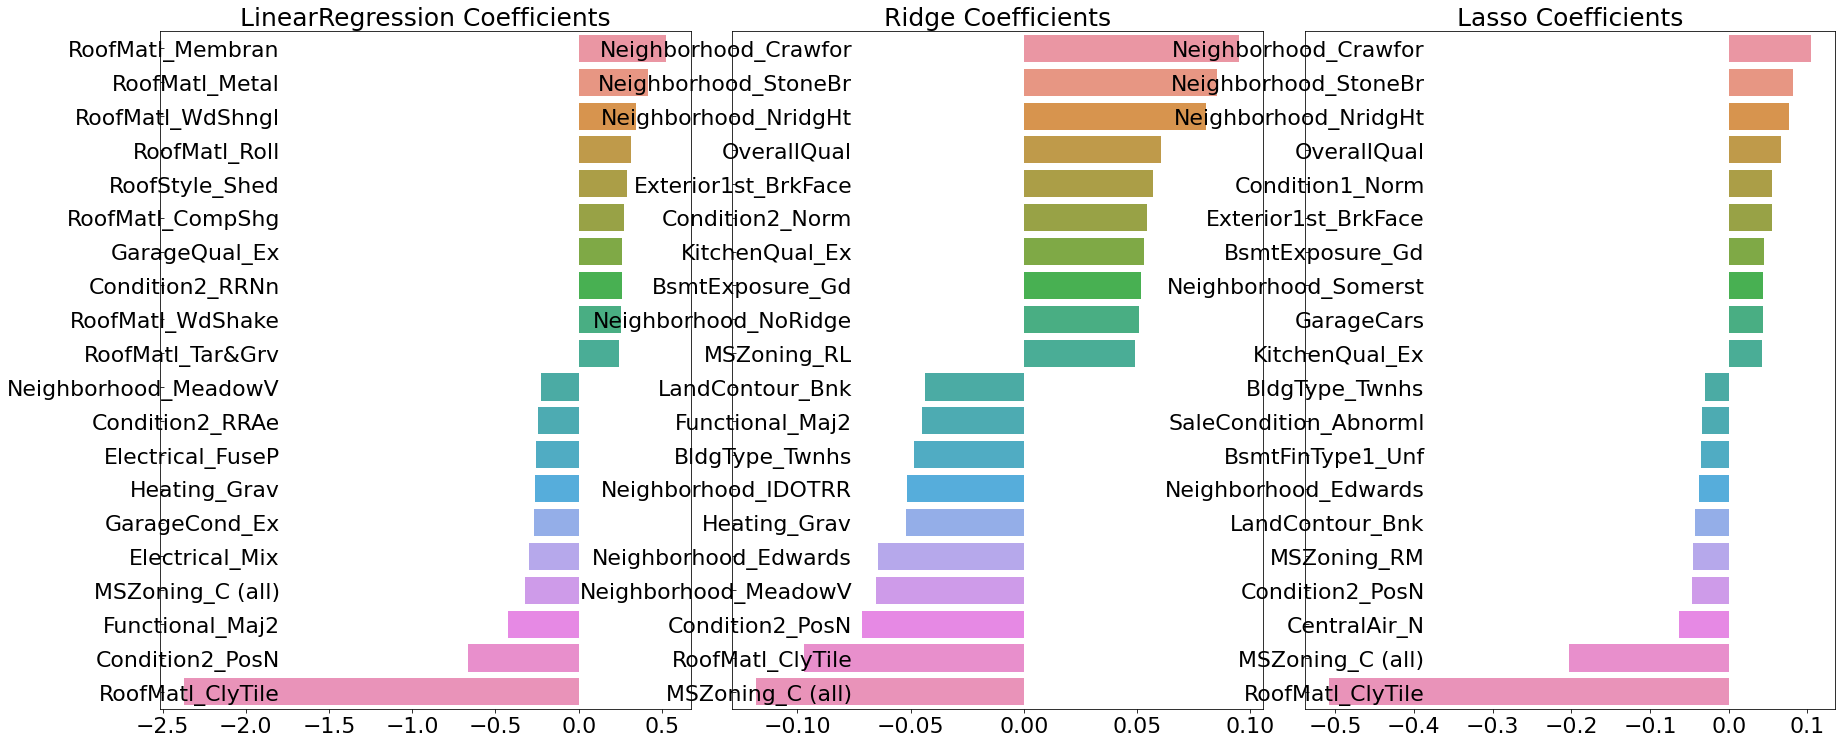

In [55]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

alpha 값 최적화 후 성능이 더 좋아졌다. 라쏘 모델의 회귀 계수가 나머지 모델과 비슷해졌다.

데이터 세트를 추가적으로 가공해서 모델 튜닝을 좀 더 진행해보자.

- 피처 데이터 세트의 분포도
- 이상치(Outlier) 데이터 처리

### 피처 데이터 세트의 분포도
scipy.stats.skew() 함수는 칼럼의 왜곡된 정도를 쉽게 추출할 수 있다. 일반적으로 (아닐수도) skew() 함수의 반환 값이 1이상인 경우를 왜곡 정도가 높다고 판단한다.

** 원-핫 인코딩된 피처는 제외하도록 주의.

In [57]:
from scipy.stats import skew

# object가 아닌 숫자형 피쳐의 컬럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew 정도가 1 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [58]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [59]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1252, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


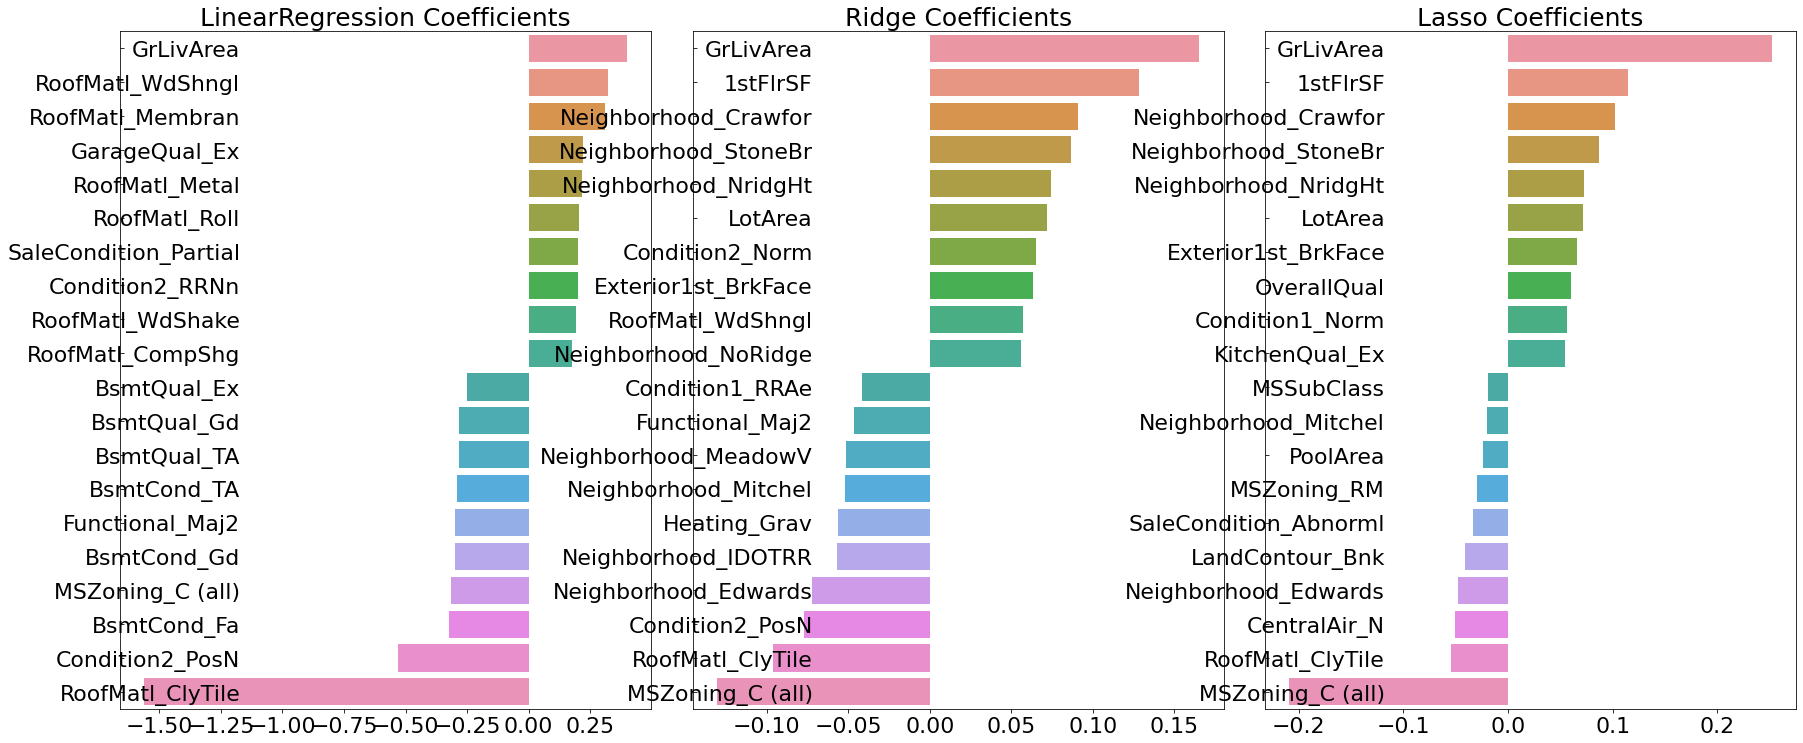

In [60]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 이상치 데이터 분석하기

회귀 계수가 높은 피처인 GrLivArea 의 데이터 분포를 살펴보자

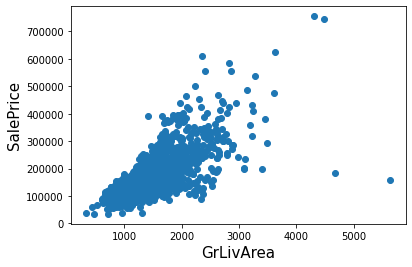

In [61]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

예상한대로 양의 상관관계가 있다는 것을 단번에 알 수 있는 그림이다. 그런데 우측 하단에 4000평방 피트 이상인데도 가격이 500000달러 이하인 이상치 데이터 2개가 존재한다. *이상치를 삭제하자!*

In [62]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성. 
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제. 
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 271)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 271)


In [63]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha:{'alpha': 0.001}


다시 하이퍼 파라미터 최적화를 수행하니, 예측 수치가 매우 크게 향상됐다.

이상치를 찾는 것은 쉽지 않지만, 회귀 계수가 높은 피처 위주로 이상치 데이터를 찾으려는 노력이 중요하다.

처음부터 완벽한 데이터 전처리를 하기는 쉽지 않다. 이렇게 데이터 가공과 모델 최적화를 반복적으로 수행하는 것이 바람직한 머신러닝 모 델 생성 과정이다.

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


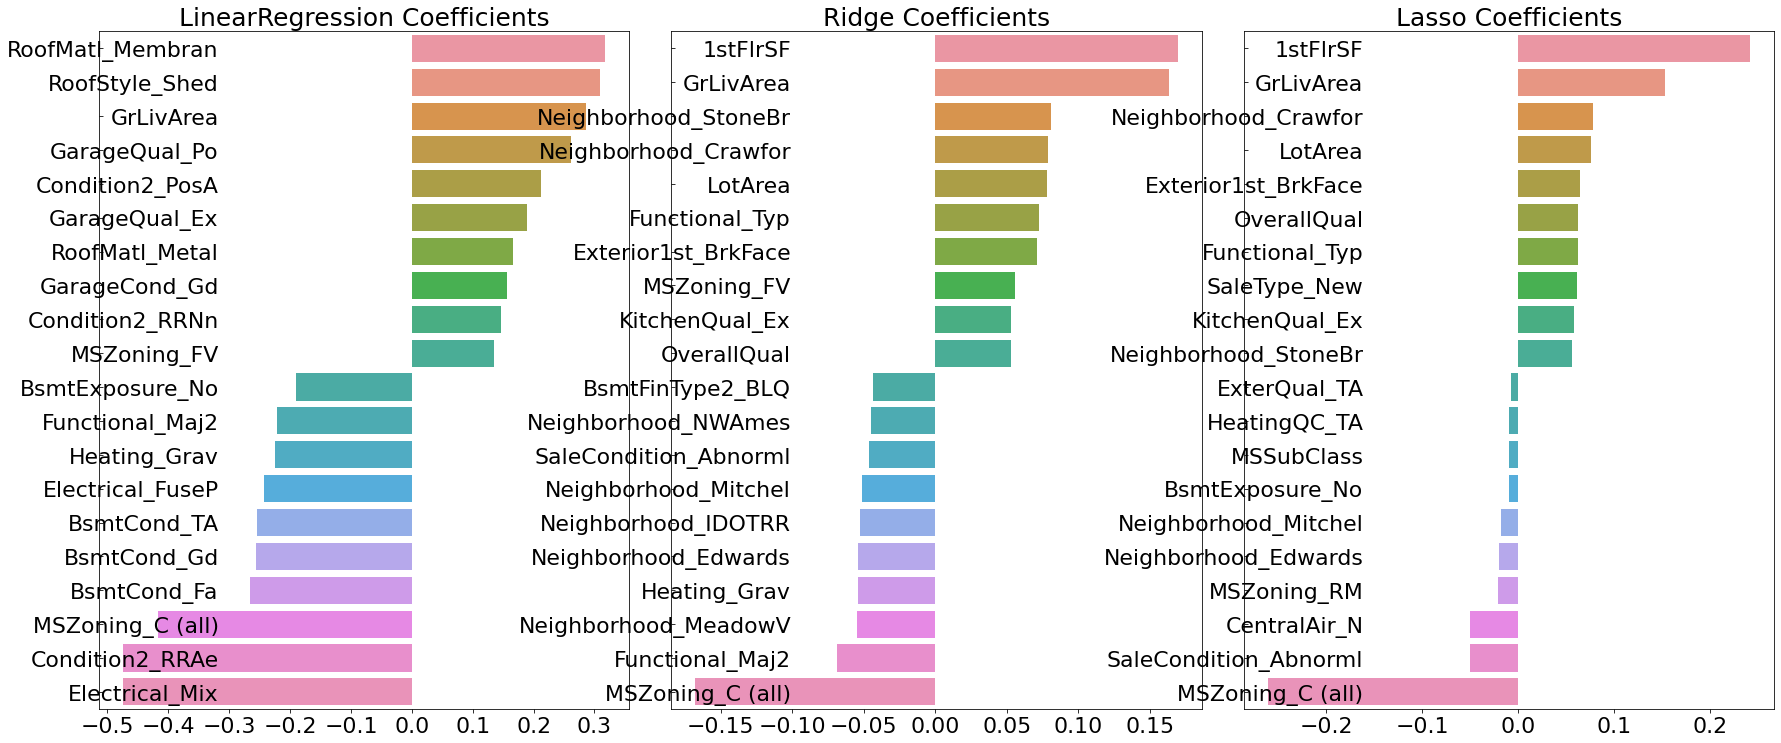

In [64]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

## 회귀 트리 모델

학습 시간 관계 상 하이퍼 파라미터 튜닝은 생략

In [67]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1186, 최적 alpha:{'n_estimators': 1000}


In [66]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1163, 최적 alpha:{'n_estimators': 1000}


트리 모델의 피처 중요도 시각화

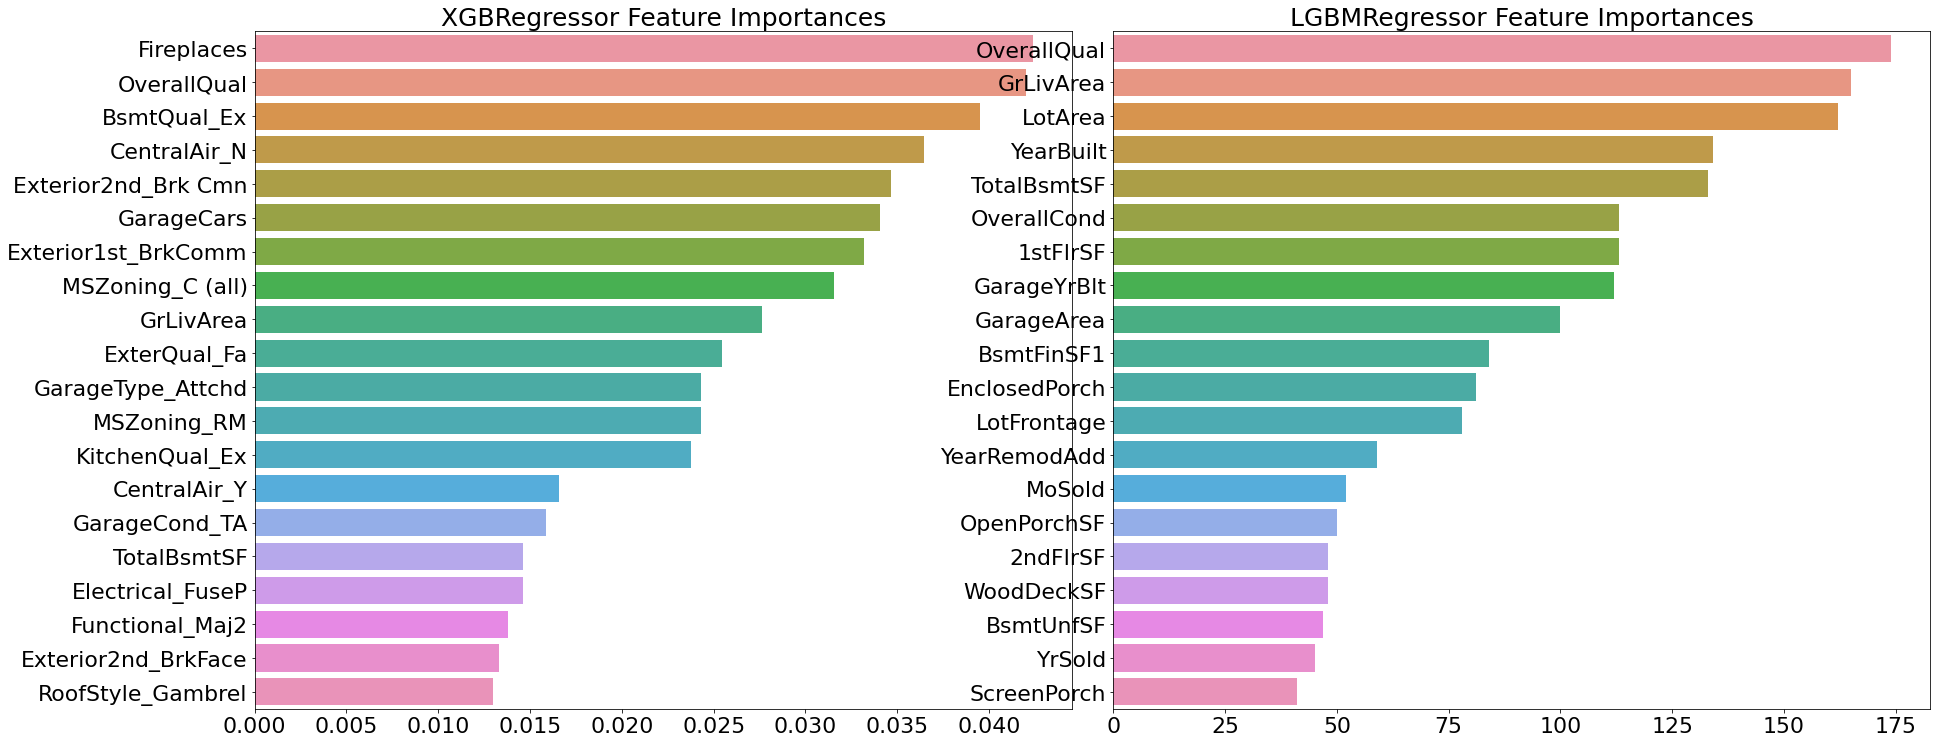

In [68]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

## 회귀 모델의 예측 결과를 혼합해서 최종 예측 해보기

In [69]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10007930884470506
Ridge 모델의 RMSE: 0.1034517754660324
Lasso 모델의 RMSE: 0.1002417046089002


In [70]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10103135866476903
XGBM 모델의 RMSE: 0.10420039960312336
LGBM 모델의 RMSE: 0.10382510019327311


## 스태킹 앙상블 모델을 통한 회귀 예측

In [71]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [72]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [73]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09738606705008673
